<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2024</strong></center>

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Javiera Donoso
- Nombre de alumno 2: Belén Órdenes


### **Link de repositorio de GitHub:** [Repositorio](https://github.com/javieradonoso/Repositorio-MDS7202)

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

In [1]:
# Librerías para importar
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [2]:
df = pd.read_csv('diabetes_data.csv')
df.head(5)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Clasificación de pacientes con diabetes (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

Tareas:
1. En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento, realice los siguientes pasos:
  * Realice una breve exploración de los datos y determine si aplicará transformaciones (MinMaxScaler, StandardScaler, etc.) en alguna/s de las variables. (1 punto)
  * Cree un conjunto de entrenamiento y uno de prueba, con una proporción de 1/3 en el conjunto de prueba. (0.5 puntos)
  * Cree un ColumnTransformer de preprocesamiento donde aplique las transformaciones determinadas anteriormente. Fije el parámetro `verbose_feature_names_out=False` y fije la salida del ColumnTransformer en formato pandas mediante el método `.set_output(transform='pandas')`. (1 punto)
  *  Cree un pipeline donde integre el preprocesamiento y el modelo `XGBoost` y entrene el modelo. Luego utilice `classification_report(..)` para reportar el desempeño del modelo. (1 punto)

Comente sus decisiones y los resultados obtenidos con el modelo.

2. Luego, le pide responder las siguientes preguntas:
  *  ¿Es acaso un buen predictor de diabetes? (0.5 puntos)
  * ¿Qué buscan explicar las métricas utilizadas? (0.5 puntos)
  * ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?(0.5 puntos)

In [3]:
#!pip install xgboost

### Pregunta 1

In [4]:
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,8.584055,0.456997,0.525703,0.975259,29.856985,0.475273,0.147810,0.703036,0.611795,0.788774,0.042721,2.837082,3.752037,5.810417,0.252730,0.062171,0.563458,0.500000
std,2.852153,0.498151,0.499342,0.155336,7.113954,0.499392,0.354914,0.456924,0.487345,0.408181,0.202228,1.113565,8.155627,10.062261,0.434581,0.241468,0.495960,0.500004
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,11.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


Al observar la base de datos, se decide utilizar las siguientes transformaciones dentro de ellos:
Variables numéricas:

- Para los valores faltantes, se decide utilizar la media para poder imputar los datos de manera completa
- Utilizamos StandardScaler para normalizar los datos numéricos

Variables categóricas:
- En el caso de datos categóricos, es preferible usar la imputación con la categoría más frecuente porque asigna el valor más común a los valores faltantes. 
- También se utiliza OneHotEncoder para las variables binarias para cada categoría, permitiendo que el modelo interprete cada categoría como una característica independiente. 

In [5]:
# Crear conjunto de train y test
X = df.drop(columns=['Diabetes'])
y = df['Diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
# Definir las columnas numéricas y categóricas
numeric_features = ['Age', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth']
categorical_features = ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack',
                        'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'DiffWalk',
                        'Stroke', 'HighBP']

# Crear los transformadores para cada tipo de característica
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

# Crear el preprocesador utilizando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')  # Configurar salida en formato pandas

# Crear el pipeline completo con el preprocesador y el modelo XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Predecir con el modelo entrenado
y_pred = pipeline.predict(X_test)

# Evaluar el rendimiento del modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:23:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.746238587166188
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.71      0.74     11651
         1.0       0.73      0.79      0.76     11678

    accuracy                           0.75     23329
   macro avg       0.75      0.75      0.75     23329
weighted avg       0.75      0.75      0.75     23329



### Pregunta 2

  *  ¿Es acaso un buen predictor de diabetes? (0.5 puntos)

 Sí, el modelo muestra un desempeño decente en la predicción de diabetes con una precisión del 75%. Además, los valores de f1-score para ambas clases indican que el modelo es equilibrado tanto en precisión como en recall. Aunque no es un modelo perfecto, tiene un rendimiento aceptable para tareas de clasificación.

  * ¿Qué buscan explicar las métricas utilizadas? (0.5 puntos)

Precisión nos indica el porcentaje de predicciones correctas para cada clase entre las predicciones realizadas para esa clase. En este contexto, ayuda a entender qué tan preciso es el modelo al identificar personas con y sin diabetes.Por otro lado el recall mide la capacidad del modelo para identificar todos los casos verdaderos de una clase. Un alto recall en la clase 1 es importante para no pasar por alto casos de diabetes. Por último, el F1-score nos ayuda a equilibrar ambas métricas, especialmente cuando se desea un modelo robusto tanto en detectar la clase positiva como en evitar falsos positivos.

  * ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?(0.5 puntos)
  
Las métricas de rendimiento no son suficientes para evaluar si el modelo ha hecho una buena selección de características, aunque las métricas indican que el modelo tiene un rendimiento aceptable, no nos dicen si todas las características utilizadas son relevantes o si algunas son redundantes o poco informativas.


## 3. Importancia de las features con XGBoost (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Tareas:
1. Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. `Hint:` Puede acceder a un paso de un pipeline por su nombre mediante el método `.named_steps[...]` (3 puntos)
2. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. (1 punto)
3. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método? (1 punto)

<Figure size 1000x800 with 0 Axes>

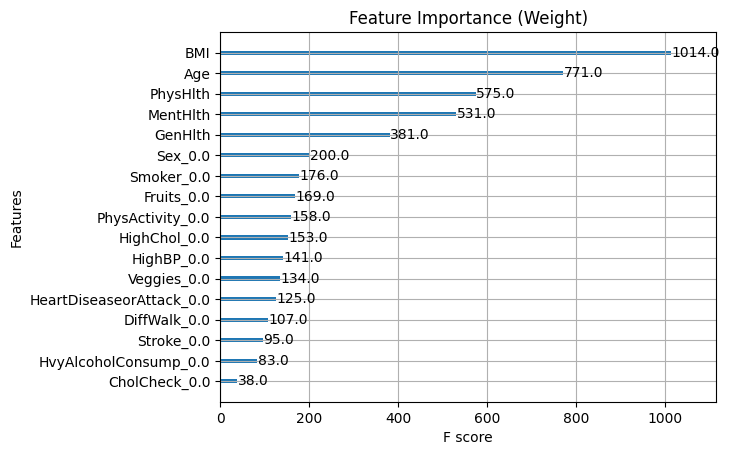

<Figure size 1000x800 with 0 Axes>

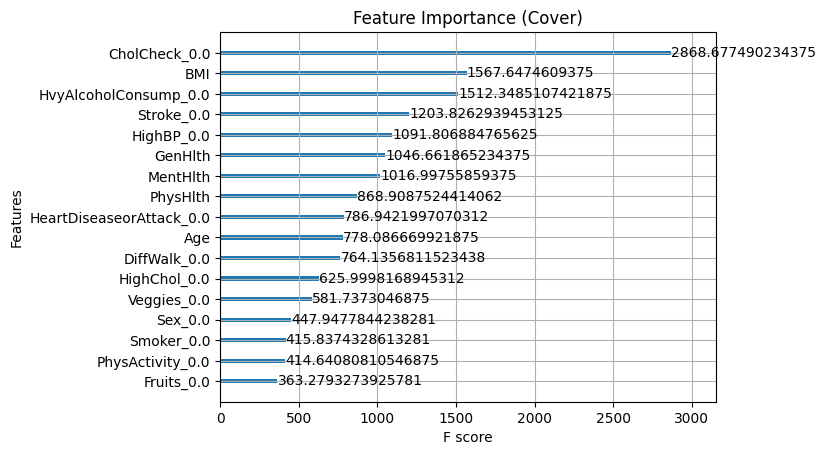

<Figure size 1000x800 with 0 Axes>

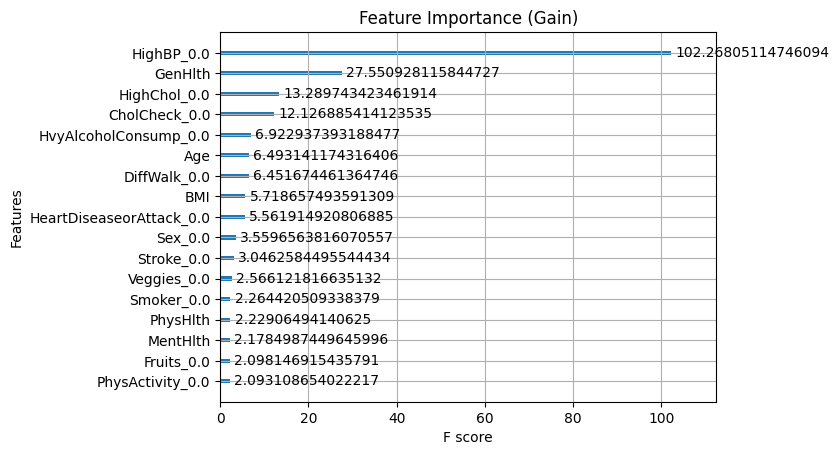

In [7]:
# Pregunta 1
# Obtener el modelo entrenado desde el pipeline
model = pipeline.named_steps['classifier']

# Mostrar la importancia de características usando cada método
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight', title="Feature Importance (Weight)")
plt.show()

plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='cover', title="Feature Importance (Cover)")
plt.show()

plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='gain', title="Feature Importance (Gain)")
plt.show()

2. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. (1 punto)

Los resultados obtenidos no son completamente compatibles, ya que cada uno mide la importancia de las características de forma distinta. *Weight* muestra las características que se usan con mayor frecuencia para dividir en los árboles, destacando BMI, Age, PhysHlth, y MentHlth. *Cover*, por otro lado, se enfoca en el número promedio de observaciones cubiertas por cada división y destaca características como CholCheck_0.0 y BMI, lo que sugiere que estas características dividen subconjuntos grandes, aunque no sean las más importantes en precisión. Finalmente, *Gain* mide la mejora promedio en precisión cada vez que se usa una característica, destacando HighBP_0.0 y GenHlth como las más impactantes en el rendimiento del modelo. Estas diferencias se deben a la forma en que cada método evalúa la relevancia: weight da prioridad a la frecuencia, cover al tamaño de los subconjuntos divididos, y gain al impacto en precisión. 

3. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método? (1 punto)

Las importancias obtenidas a partir de estos métodos no son suficientes para obtener una interpretabilidad completa de un modelo que utiliza árboles, ya que presentan varias limitaciones. En primer lugar, ofrecen una interpretación global de las características importantes, pero no permiten entender cómo estas características afectan las predicciones individuales, lo cual es crucial en aplicaciones médicas donde es importante saber por qué el modelo considera que un paciente tiene un alto o bajo riesgo de diabetes. Además, el método de importancia de características puede presentar un sesgo hacia aquellas variables con más categorías o que se usan más frecuentemente en las divisiones, lo cual no necesariamente refleja su relevancia en el contexto del problema. 

## 4. Métodos Agnósticos Globales (10 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Tareas:
1. Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. `Nota:`Tenga cuidado con el orden de las columnas de este método. `Hint:` Puede obtener los features del clasificador con su respectivo orden mediante el método `.get_booster().feature_names` (2 puntos)
2. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala esta?). (2 puntos)
3. Visualice los resultados de este método en un gráfico. (2 puntos)
4. Además, responda las siguientes preguntas:
  - ¿Cómo mide la importancia de las features su propuesta? (1 punto)
  - ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido? (1 punto)
  - ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior? (1 punto)
  - Nombre y explique 3 ventajas y 3 desventajas del método implementado. (1 punto)

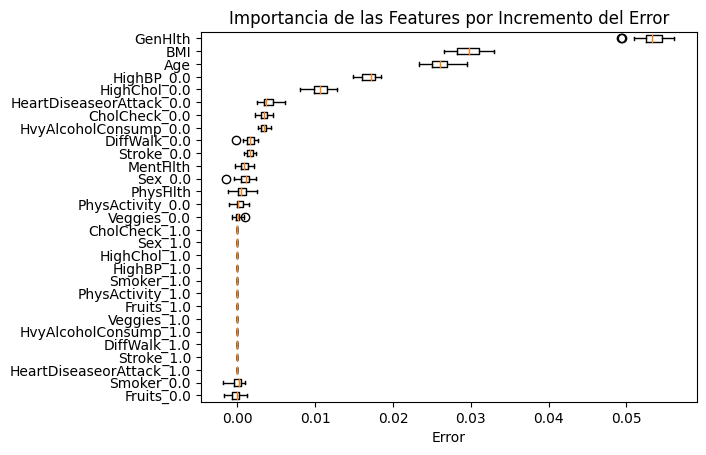

In [8]:
#Pregunta 1
# Aplicar el preprocesador al conjunto de prueba para asegurar que las características coincidan
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Realizar la permutación y obtener importancia de características
result = permutation_importance(model, X_test_transformed, y_test, n_repeats=30, random_state=42)

# Ordenar las importancias
perm_sorted_idx = result.importances_mean.argsort()

# Visualizar importancias
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(model.get_booster().feature_names)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

### Pregunta 2
La desviación estándar en el gráfico representa la variabilidad en la pérdida de precisión del modelo al permutar cada característica, repetida varias veces. Una desviación estándar baja indica que el impacto de la característica en el modelo es consistente en cada permutación, lo que sugiere que el modelo depende de esa característica de manera estable.

### Pregunta 4

  - ¿Cómo mide la importancia de las features su propuesta? (1 punto)

La importancia de las características se mide mediante el método de permutación, el cual evalúa la pérdida en la precisión del modelo cuando los valores de una característica son permutados aleatoriamente. Si la permutación de una característica específica causa una disminución considerable en la precisión, esa característica se considera importante, ya que indica que el modelo depende de ella para realizar predicciones precisas. En contraste, si la permutación no afecta la precisión, esa característica se considera menos relevante.

  - ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido? (1 punto)

Las cinco características con mayor impacto son GenHlth, BMI, Age, HighBP, y HighChol. Estas características tienen sentido en el contexto de la predicción de diabetes, ya que se relacionan directamente con factores de salud física y hábitos que suelen estar asociados con la diabetes. GenHlth refleja la percepción general de la salud, y BMI es un indicador clave de obesidad, un factor de riesgo conocido para la diabetes. Age también es importante, ya que el riesgo de diabetes tipo 2 aumenta con la edad. Finalmente, HighBP (presión arterial alta) y HighChol (colesterol alto) son condiciones que suelen estar correlacionadas con la diabetes, lo que refuerza la importancia de estas características en el modelo.

  - ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior? (1 punto)

  A diferencia de los métodos anteriores, el método de permutación proporciona una visión más directa de cómo cada característica afecta el rendimiento del modelo en términos de precisión. En el análisis anterior, algunas características tenían alta importancia debido a su frecuencia de uso en divisiones o su cobertura de observaciones, pero esto no siempre reflejaba su impacto en la precisión. La permutación muestra que características como GenHlth, BMI, y Age tienen un impacto significativo en la precisión, lo que indica que el modelo realmente depende de ellas para hacer predicciones precisas.

  - Nombre y explique 3 ventajas y 3 desventajas del método implementado. (1 punto)
  
Ventajas: 
- Fácil interpretación.
- Alta compresión de interpretabilidad global.
- Comparable con diferentes modelos.
- Toma en cuenta las interacciones.
- No necesita re-entrenar el modelo.


Desventajas:
- Enlazado al error del modelo.
- Necesitas acceso a la gold label.
- Si las features están correlacionadas puede generar sesgos por entradas poco realistas.
- Añadir una feature correlacionada puede decrecer la importancia de una feature asociada al separar la importancia en las dos features.

## 5. Métodos Agnósticos Locales (20 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/10-24-2024/oMCrLI.gif" width="400">
</p>

### 5.1 Calculando Shap Values (4 puntos)

Tareas:
1. Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. (2 puntos)
2. ¿Qué representa cada número en su resultado? (1 punto)
3. ¿Es posible atribuir un significado a la positividad/negatividad de cada valor? (1 punto)

In [9]:
#!pip install shap

In [10]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [11]:
# Inserte código para calcular shapley values aquí
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_transformed)

In [12]:
shap_values

.values =
array([[ 0.19122018, -0.69601214,  1.059766  , ...,  0.        ,
        -0.65515095,  0.        ],
       [ 0.63485146,  0.5168076 ,  0.23844224, ...,  0.        ,
        -0.61570835,  0.        ],
       [-0.17223914, -0.23818094, -0.6969643 , ...,  0.        ,
         0.5085205 ,  0.        ],
       ...,
       [-0.8383674 , -0.9962655 , -0.69009244, ...,  0.        ,
        -0.6052742 ,  0.        ],
       [ 0.25314033,  0.32437342,  0.19043794, ...,  0.        ,
         0.48668748,  0.        ],
       [-1.562156  , -0.11054382, -1.3684413 , ...,  0.        ,
        -0.7033418 ,  0.        ]], dtype=float32)

.base_values =
array([-0.00905643, -0.00905643, -0.00905643, ..., -0.00905643,
       -0.00905643, -0.00905643], dtype=float32)

.data =
array([[ 0.49892888, -0.96642111,  1.0501395 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.55049387,  0.43841784,  0.15190828, ...,  0.        ,
         1.        ,  0.        ],
       [-0.20211445, -0.

2. ¿Qué representa cada número en su resultado? (1 punto)

Cada número en los resultados de SHAP values representa la contribución de una característica específica a la predicción del modelo en este caso es tener o no diabetes

3. ¿Es posible atribuir un significado a la positividad/negatividad de cada valor? (1 punto)

Si es posible, y para este caso tenemos dos:

*   Valor de SHAP positivo: Indica que la característica ha incrementado la probabilidad de tener diabetes
*   Valor de SHAP negativo: Indica que la característica ha disminuido la probabilidad de tener diabetes


### 5.2 Aporte local (4 puntos)

1. Usando los *shap values* calculados, grafique el **aporte local** de las diferentes variables para las instancias **1**, **9** y **150** (1 punto).

2. Interprete sus resultados y responda:

  - ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? (1 punto)

  - ¿Existe algún patrón común entre las instancias analizadas? (1 punto)

  - ¿Es posible generalizar estas conclusiones a todo el dataset? (1 punto)

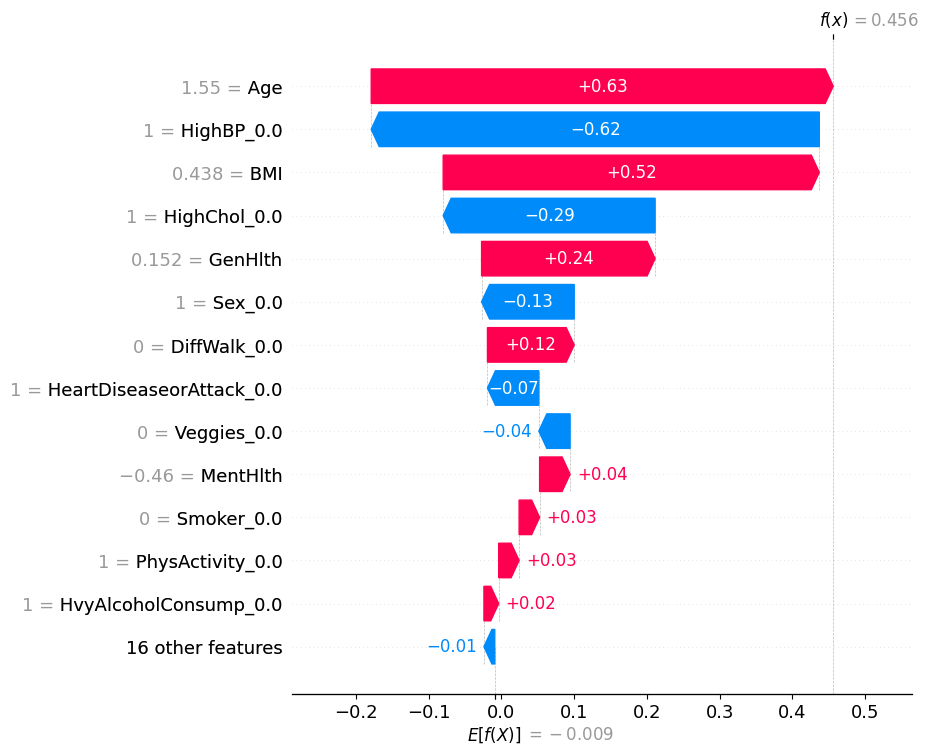

In [13]:
idx=1
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

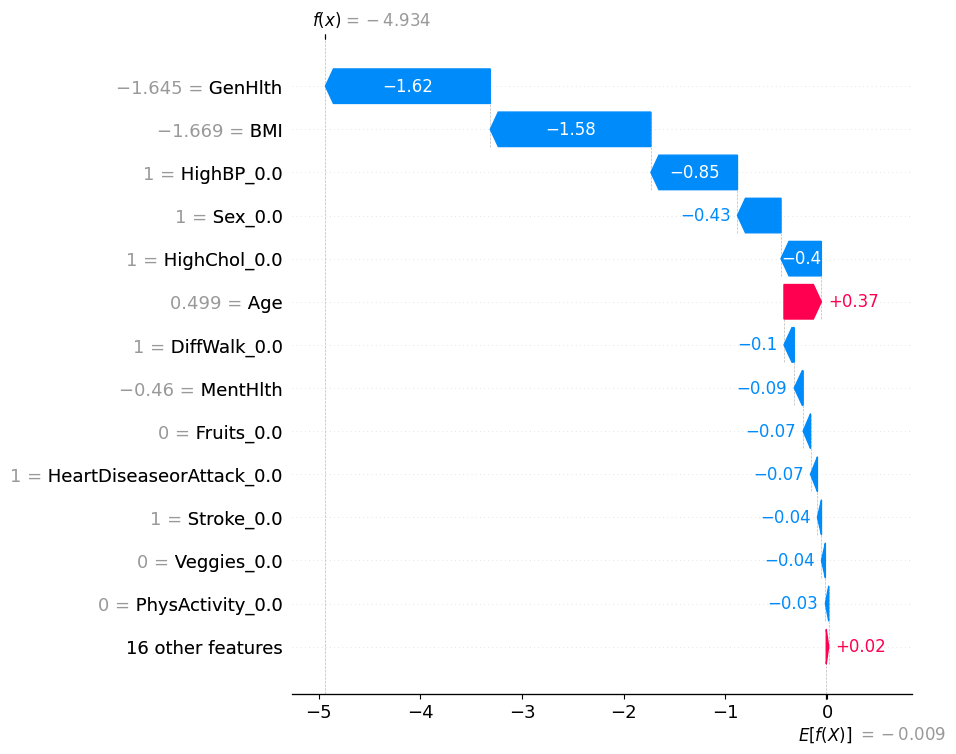

In [14]:
idx=9
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

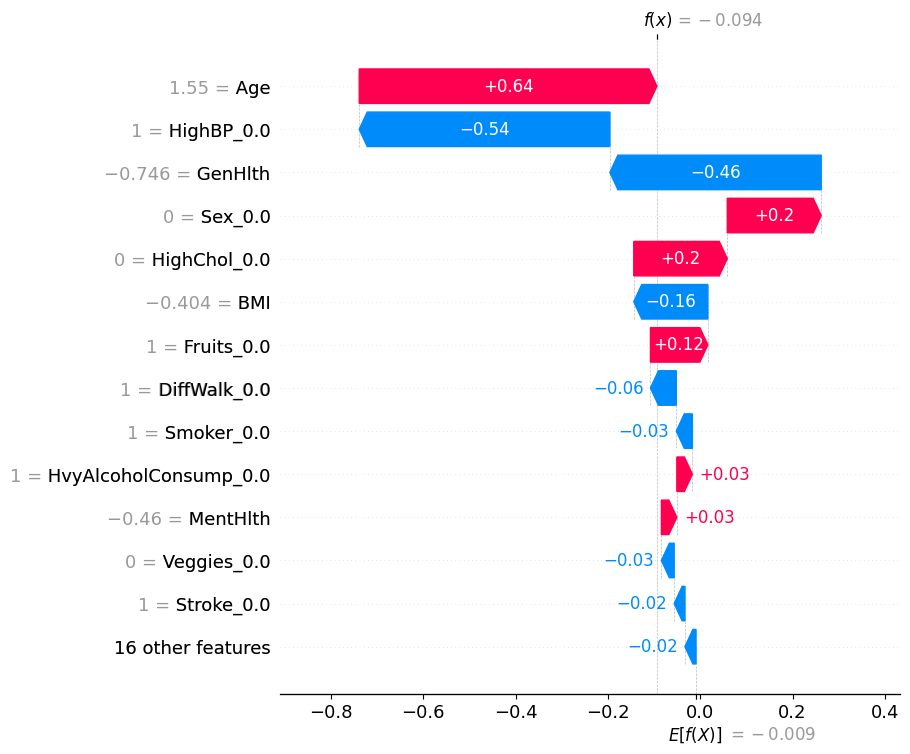

In [15]:
idx=150
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

 - ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? (1 punto)
 
 Para la instancia 1 las variables que aumentan la probabilidad de diabetes son Age, BMI, GenHlth, Sex_0.0, DiffWalk_0.0. Mientras que las que disminuyen la probabilidad de diabetes son HighBP_0.0, HighChol_0.0, MentHlth, Smoker_0.0.

Para la instancia 9 las variables que aumentan la probabilidad de diabetes son Age, HighBP_0.0. Por otro lado, las variables que disminuyen la probabilidad de diabetes son GenHlth, BMI, MentHlth.

Para la instancia 150, las variables que aumentan la probabilidad de diabetes son Age, GenHlth, HighChol_0.0. Mientras que las variables que disminuyen la probabilidad de diabetes son BMI, DiffWalk_0.0, Smoker_0.0, MentHlth.

  - ¿Existe algún patrón común entre las instancias analizadas? (1 punto)

Sí  hay patrones comunes observables, por ejemplo, Age es una variable que en todas las instancias tiene un impacto positivo en la probabilidad de tener diabetes, lo cual es lógico, ya que el riesgo de diabetes tiende a aumentar con la edad. Además, variables como GenHlth y MentHlth tienden a tener un efecto negativo en la probabilidad, lo que sugiere que una mejor percepción de la salud general y mental está asociada con un menor riesgo de diabetes.

  - ¿Es posible generalizar estas conclusiones a todo el dataset? (1 punto)

No es posible, porque si bien los SHAP values proporcionan interpretaciones a nivel local, pero en las observaciones se muestra que las características como Age y GenHlth, que muestran un impacto consistente en estas instancias y se debería observar a nivel global. Además dentro de cada instancia ocurren cambios en las probabilidades, lo que no es posible generalizar.


### 5.3 Aporte global (4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

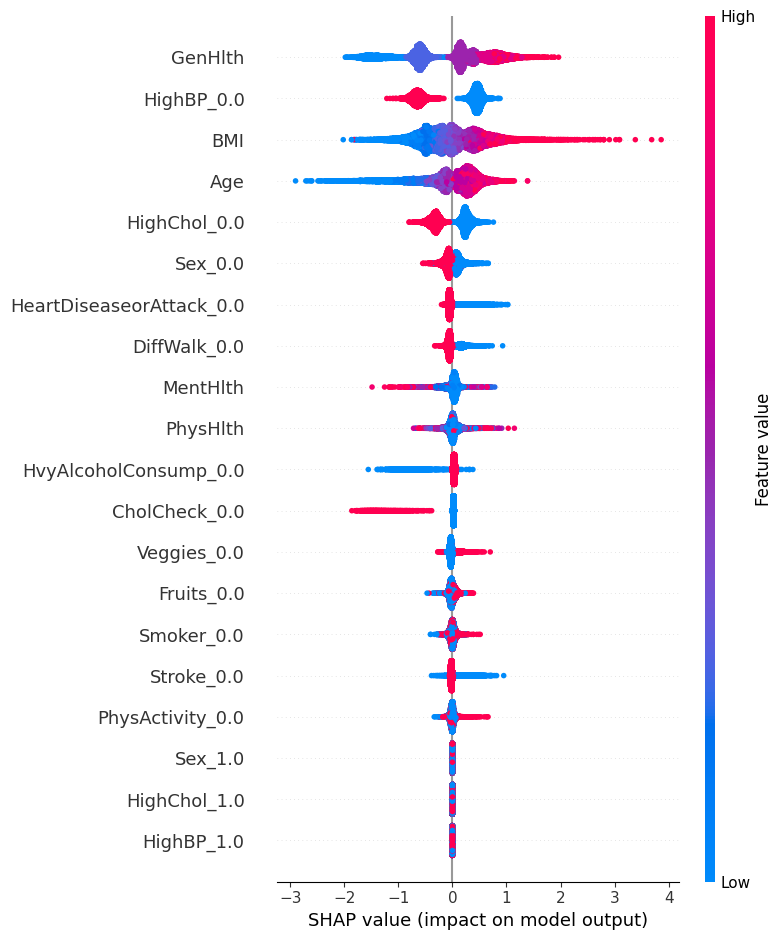

In [16]:
# Inserte código para generar gráficos de aporte global aquí
shap.summary_plot(shap_values, X_test_transformed)

- ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

A nivel global, se puede observar las características que en promedio tienen un impacto significativo en la predicción de diabetes, destacando variables como GenHlth, HighBP, BMI y Age como factores claves en todo el dataset. Esto contrasta con el análisis a nivel de instancia, donde el impacto de cada característica se observó de manera específica para cada caso individual, revelando variabilidad en cómo estas características afectan cada predicción. En el gráfico global, además, podemos ver cómo los valores altos y bajos de cada característica influyen en la probabilidad de diabetes de manera consistente en el conjunto de datos, algo que no es tan evidente a nivel de instancia. 

### 5.4 Scatter plot (4 puntos)


Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [17]:
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_test_transformed.columns[shap_values_abs.argsort()[::-1]]

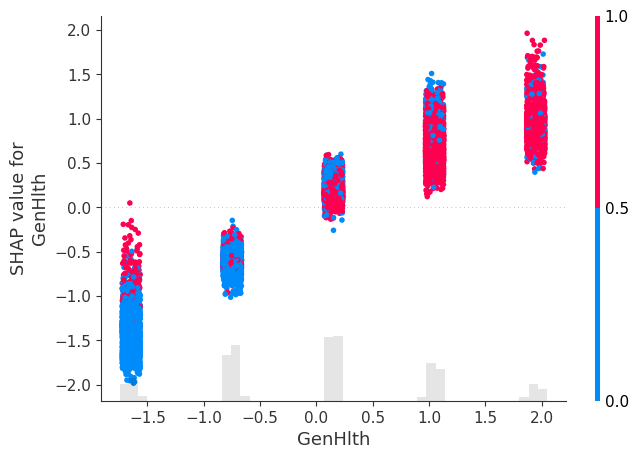

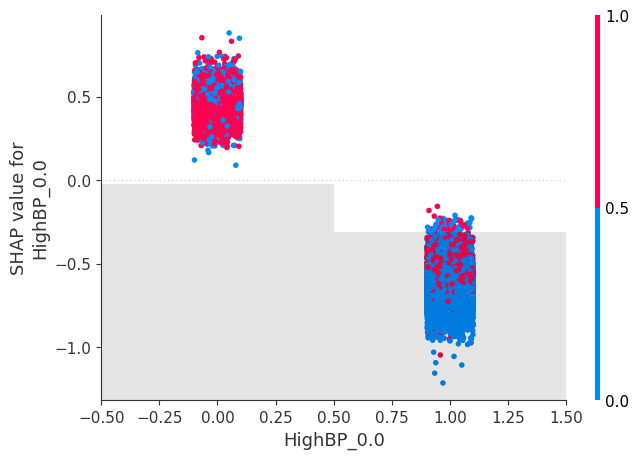

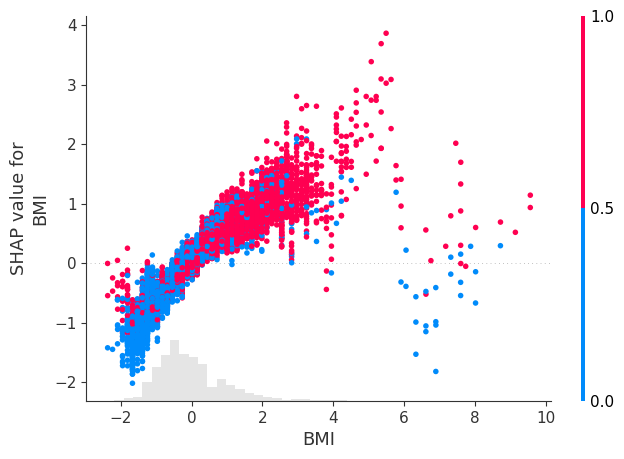

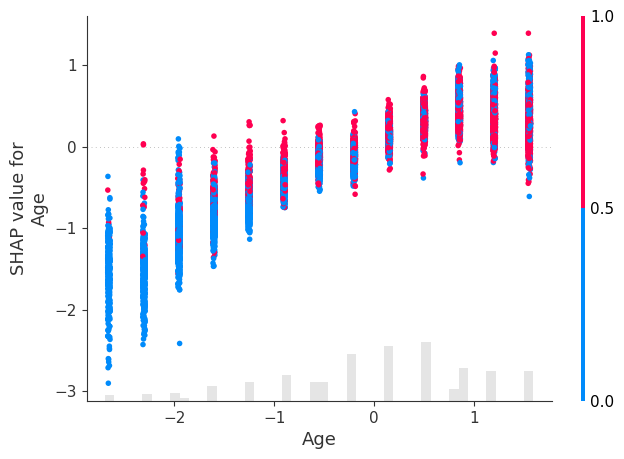

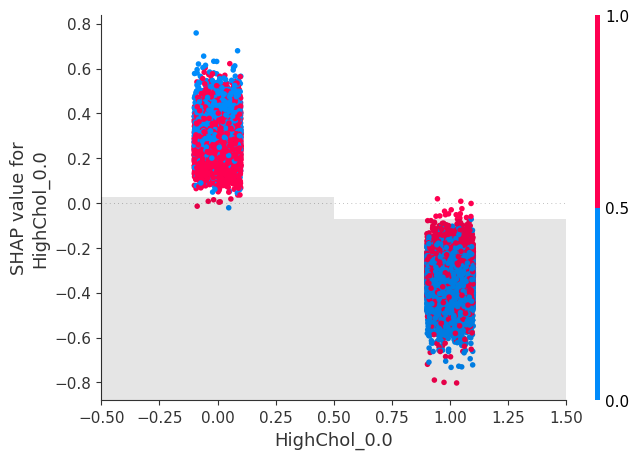

In [18]:
for name in feature_importance_names[:5]:
    color = model.predict(X_test_transformed)  # Predicción para todo el conjunto de datos
    shap.plots.scatter(shap_values[:,name],
                       color = color)


- ¿Qué puede concluir de sus resultados?

Los gráficos de dispersión de los valores SHAP muestran que las cinco características principales tienen un impacto significativo en la predicción de diabetes. Valores más altos en BMI, Age y la presencia de HighBP y HighChol tienden a aumentar la probabilidad de predecir diabetes.

### 5.5 Partial Dependence Plot (4 puntos)

Finalmente, se le pide generar un gráfico del tipo Partial Dependence Plot para las mismas 5 variables con mayor impacto global usando una submuestra de 1000 observaciones. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

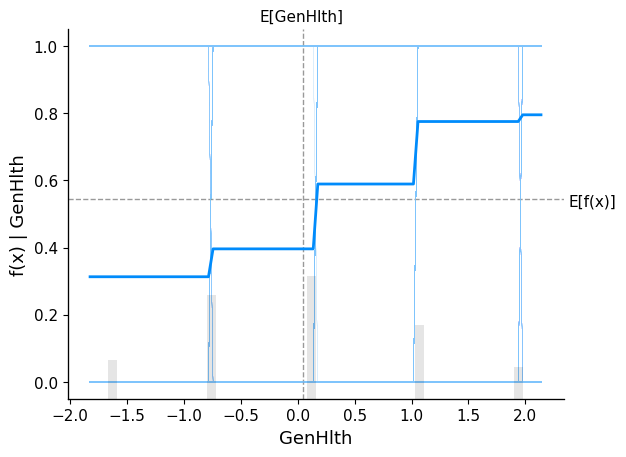

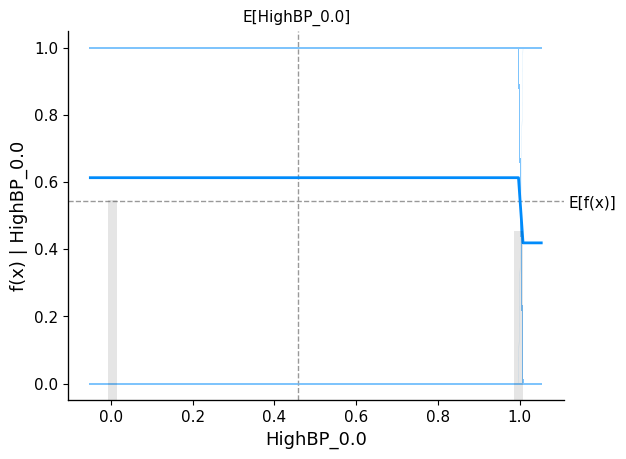

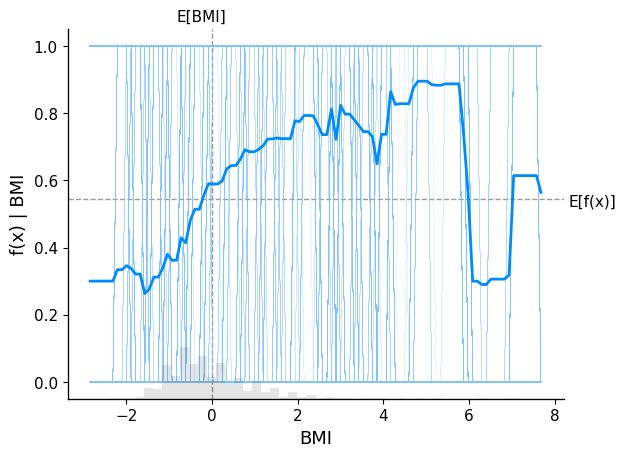

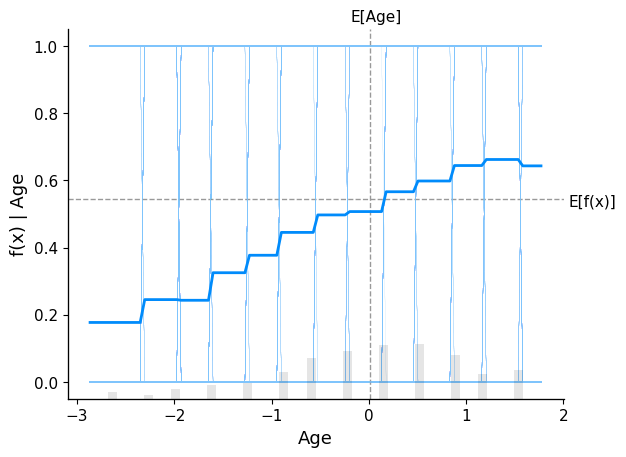

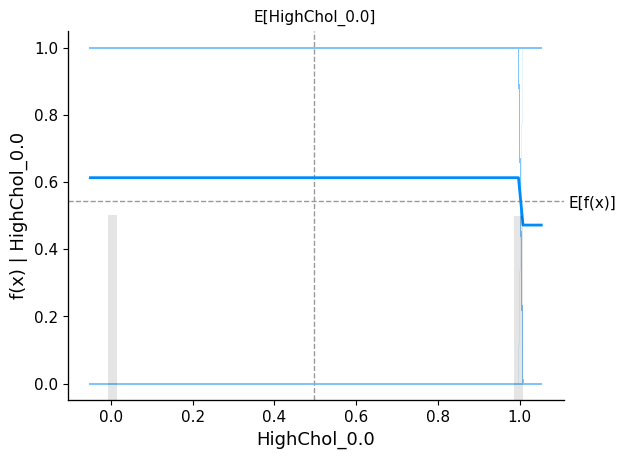

In [19]:
# Seleccionar las 5 variables con mayor impacto global
top_features = feature_importance_names[:5]

# Obtener una submuestra de 1000 observaciones
X1000 = shap.utils.sample(X_test_transformed, 1000, random_state=42)

# Generar el Partial Dependence Plot para las 5 variables seleccionadas
for feature_name in top_features:
    shap.partial_dependence_plot(
        feature_name, 
        model.predict, 
        X1000, 
        model_expected_value=True,
        feature_expected_value=True, 
        ice=True
    )

¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

A partir de los gráficos podemos observar la relación entre cada característica y la salida promedio del modelo en términos de la probabilidad de predecir diabetes. Por ejemplo, variables como GenHlth y BMI muestran una relación positiva: a medida que aumentan, la probabilidad de tener diabetes tiende a aumentar. En contraste, factores binarios como HighBP_0.0 y HighChol_0.0 muestran variaciones más discretas en la salida del modelo debido a su naturaleza categórica.

Las conclusiones observadas para estas cinco características pueden ser representativas para el conjunto de datos, especialmente si estos son factores de riesgo conocidos para la diabetes en la población general. Sin embargo, debido a que los PDPs muestran relaciones promedio y no capturan todas las interacciones posibles entre variables, pueden no reflejar completamente las complejidades del conjunto de datos completo.

## 6. Sistema de Reglas! (10 punto)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. 
En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

`Hint:` Como debe entregar las columnas que entran al clasificador entrenado de su pipeline, le será útil extraer el paso de preprocesamiento y generar dataframes preprocesados para el conjunto `train` y `test`. 

In [20]:
#!pip install alibi

In [65]:
# Extraer el preprocesador
preprocessor = pipeline.named_steps['preprocessor']

# Preprocesar los conjuntos de datos train y test
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [66]:
predict_fn = lambda x: model.predict(x) # creamos función de predicción
explainer = AnchorTabular(predict_fn, model.feature_names_in_, seed=1) # instanciamos Anchor usando función creada
explainer.fit(X_train_transformed.to_numpy()) # sobre los datos


AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': (25, 50, 75)},
  'version': '0.9.6'}
)

In [68]:
print("Explicación para 1000")
idx = 1000 # índice obs a predecir
obs = np.array(X_test_transformed.iloc[idx], ndmin = 2) # array de la obs

explanation = explainer.explain(obs, threshold=0.95) # generar anchor
print('Prediction: ', explainer.predictor(X_test_transformed.to_numpy()[idx].reshape(1, -1))[0]) # obtener prediccion del modelo 
print('Anchor: %s' % (' AND '.join(explanation.anchor))) # obtener regla 
print('Precision: %.2f' % explanation.precision) # obtener precision
print('Coverage: %.2f' % explanation.coverage) # obtener cobertura


print("Explicación para 3001")
idx = 3001 # índice obs a predecir
obs = np.array(X_test_transformed.iloc[idx], ndmin = 2) # array de la obs

explanation = explainer.explain(obs, threshold=0.95) # generar anchor
print('Prediction: ', explainer.predictor(X_test_transformed.to_numpy()[idx].reshape(1, -1))[0]) # obtener prediccion del modelo 
print('Anchor: %s' % (' AND '.join(explanation.anchor))) # obtener regla 
print('Precision: %.2f' % explanation.precision) # obtener precision
print('Coverage: %.2f' % explanation.coverage) # obtener cobertura


print("Explicación para 5751")
idx = 5751 # índice obs a predecir
obs = np.array(X_test_transformed.iloc[idx], ndmin = 2) # array de la obs

explanation = explainer.explain(obs, threshold=0.95) # generar anchor
print('Prediction: ', explainer.predictor(X_test_transformed.to_numpy()[idx].reshape(1, -1))[0]) # obtener prediccion del modelo 
print('Anchor: %s' % (' AND '.join(explanation.anchor))) # obtener regla 
print('Precision: %.2f' % explanation.precision) # obtener precision
print('Coverage: %.2f' % explanation.coverage) # obtener cobertura

Explicación para 1000
Prediction:  1
Anchor: Age > 0.15 AND HeartDiseaseorAttack_1.0 > 0.00 AND BMI > -0.69
Precision: 0.96
Coverage: 0.08
Explicación para 3001
Prediction:  1
Anchor: BMI > 0.44 AND HighBP_0.0 <= 0.00 AND GenHlth > -0.75
Precision: 0.96
Coverage: 0.14
Explicación para 5751
Prediction:  0
Anchor: GenHlth <= -0.75 AND HighBP_0.0 > 0.00 AND BMI <= -0.69
Precision: 0.99
Coverage: 0.11


¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

Si tienen sentido, por ejemplo, se puede observar que la regla propuesta para la observación de índice 1000 es válida para el 8% de la población, y para ese 8% va a estar correcta el 96% de las veces (eso nos dice precision). Para el caso del índice 3001 Luego la regla de la observación de indice 3001 es para el 14% de la población con un 96% sobre ese conjunto. Por último, la regla de la observación de índice 5751 es válida para el 11% de la población, y para ese 11% va a ser correcta con un 99% de precisión. Con esto en mente, se puede decir que las reglas si tienen sentido, ya que son reglas que se basan en las características más importantes encontradas en los análisis globales de importancia. 

# Retrospectiva... (10 puntos)

- En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

Los métodos que permiten entregar mejores conclusiones depende del enfoque que queremos, no obstante, el método SHAP entrega conclusiones tanto a nivel local como general, por lo qué, este método podría ser el mejor para la tarea de clasificación siendo más robusto pero tiene un alto costo computacional. En contraparte, se le podría agregar el Sistema de reglas proporcionando facilidades en torno a instancias especificas, sirviendo para casos particulares.

Para lo que busca DR.SIMI sería mejor el sistema de reglas debido a que los diagnosticos son a nivel local/individuo y no de manera global, siendo de mucha utilidad esté método para explicar la predicción de manera clara y comprensible. Aunque, de igual manera se podría ocupar SHAP para tener una visión más global y local.


# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>